# **Loading The MNIST Datasets from Runtime File Directory**

In [32]:
import os
import struct
import numpy as np

def load_mnist(path, kind='train'):
  labels_path = os.path.join(path, '%s-labels-idx1-ubyte' % kind)
  images_path = os.path.join(path, '%s-images-idx3-ubyte' % kind)

  with open(labels_path, 'rb') as lbpath:
    magic, n = struct.unpack('>II', lbpath.read(8))
    labels = np.fromfile(lbpath, dtype=np.uint8)

  with open(images_path, 'rb') as imgpath:
    magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
    images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)
    images = ((images / 255.) - .5) * 2

  return images, labels



X_train, y_train = load_mnist('', kind='train')
print('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))

X_test, y_test = load_mnist('', kind='t10k')
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

Rows: 60000, columns: 784
Rows: 10000, columns: 784


# **Sneak Peek**

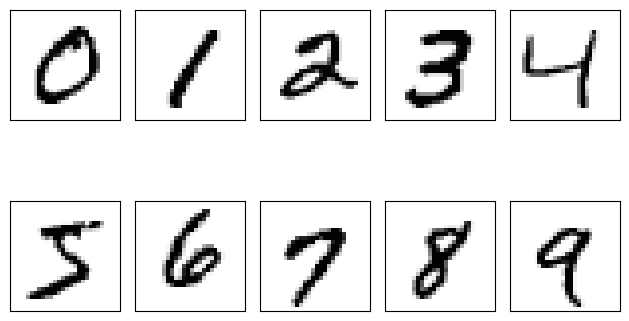

In [33]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)

ax = ax.flatten()

for i in range(10):
  img = X_train[y_train == i][0].reshape(28, 28)
  ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])

plt.tight_layout()

plt.show()

# **First 25 Variants of The Digit `7`**

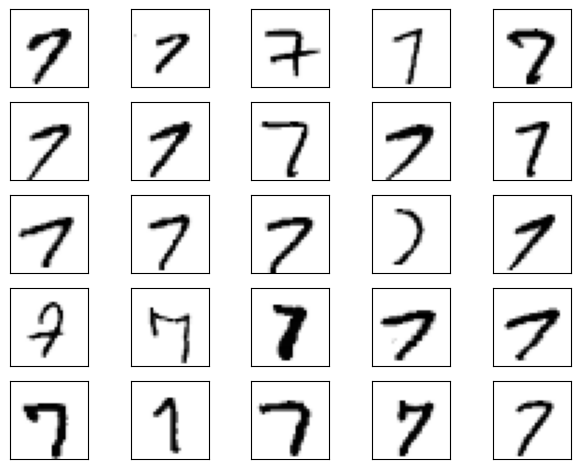

In [34]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)

ax = ax.flatten()

for i in range(25):
  img = X_train[y_train == 7][i].reshape(28, 28)
  ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])

plt.tight_layout()

plt.show()

# **Saving The Already Loaded Files to a `.npz` File using `np.savez_compressed()` for Quick Loading in the Future**

In [35]:
np.savez_compressed('mnist_scaled.npz', X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)


#Now loading from the .npz file:
mnist = np.load('mnist_scaled.npz')

#Sneak peek:
mnist.files

#Getting the data arrays back into code:
X_train, y_train, X_test, y_test = [mnist[f] for f in mnist.files]

# **Implementing a Multilayer Perceptron**

In [36]:
import numpy as np
import sys

class NeuralNetMLP(object):

  def __init__(self, n_hidden=30, l2=0., epochs=100, eta=0.001, shuffle=True, minibatch_size=1, seed=None):
    self.random = np.random.RandomState(seed)
    self.n_hidden = n_hidden
    self.l2 = l2
    self.epochs = epochs
    self.eta = eta
    self.shuffle = shuffle
    self.minibatch_size = minibatch_size



  def _onehot(self, y, n_classes):
    onehot = np.zeros((n_classes, y.shape[0]))

    for idx, val in enumerate(y.astype(int)):
      onehot[val, idx] = 1.

    return onehot.T



  def _sigmoid(self, z):
    return 1. / (1. + np.exp(-np.clip(z, -250, 250)))



  def _forward(self, X):
    z_h = np.dot(X, self.w_h) + self.b_h
    a_h = self._sigmoid(z_h)

    z_out = np.dot(a_h, self.w_out) + self.b_out
    a_out = self._sigmoid(z_out)

    return z_h, a_h, z_out, a_out



  def _compute_cost(self, y_enc, output):
    L2_term = (self.l2 * (np.sum(self.w_h ** 2.) + np.sum(self.w_out ** 2.)))

    term1 = -y_enc * (np.log(output))
    term2 = (1. - y_enc) * np.log(1. - output)

    cost = np.sum(term1 - term2) + L2_term

    return cost



  def predict(self, X):
    z_h, a_h, z_out, a_out = self._forward(X)

    y_pred = np.argmax(z_out, axis=1)

    return y_pred



  def fit(self, X_train, y_train, X_valid, y_valid):
    n_output = np.unique(y_train).shape[0]
    n_features = X_train.shape[1]

    self.b_h = np.zeros(self.n_hidden)
    self.w_h = self.random.normal(loc=0.0, scale=0.1, size=(n_features, self.n_hidden))

    self.b_out = np.zeros(n_output)
    self.w_out = self.random.normal(loc=0.0, scale=0.1, size=(self.n_hidden, n_output))

    epoch_strlen = len(str(self.epochs))

    self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}

    y_train_enc = self._onehot(y_train, n_output)

    for i in range(self.epochs):
      indices = np.arange(X_train.shape[0])

      if self.shuffle:
        self.random.shuffle(indices)

      for start_idx in range(0, indices.shape[0] - self.minibatch_size + 1, self.minibatch_size):
        batch_idx = indices[start_idx:start_idx + self.minibatch_size]

        z_h, a_h, z_out, a_out = self._forward(X_train[batch_idx])

        delta_out = a_out - y_train_enc[batch_idx]

        sigmoid_derivative_h = a_h * (1. - a_h)

        delta_h = (np.dot(delta_out, self.w_out.T) * sigmoid_derivative_h)

        grad_w_h = np.dot(X_train[batch_idx].T, delta_h)
        grad_b_h = np.sum(delta_h, axis=0)

        grad_w_out = np.dot(a_h.T, delta_out)
        grad_b_out = np.sum(delta_out, axis=0)

        delta_w_h = (grad_w_h + self.l2*self.w_h)
        delta_b_h = grad_b_h

        self.w_h -= self.eta * delta_w_h
        self.b_h -= self.eta * delta_b_h

        delta_w_out = (grad_w_out + self.l2*self.w_out)
        delta_b_out = grad_b_out

        self.w_out -= self.eta * delta_w_out
        self.b_out -= self.eta * delta_b_out

      z_h, a_h, z_out, a_out = self._forward(X_train)

      cost = self._compute_cost(y_enc=y_train_enc, output=a_out)

      y_train_pred = self.predict(X_train)
      y_valid_pred = self.predict(X_valid)

      train_acc = ((np.sum(y_train == y_train_pred)).astype(float) / X_train.shape[0])

      valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(float) / X_valid.shape[0])

      sys.stderr.write('\r%0*d/%d | Cost: %.2f | Train/Valid Acc.: %.2f%%/%.2f%% ' % (epoch_strlen, i+1, self.epochs, cost, train_acc*100, valid_acc*100))

      sys.stderr.flush()

      self.eval_['cost'].append(cost)
      self.eval_['train_acc'].append(train_acc)
      self.eval_['valid_acc'].append(valid_acc)

    return self

In [37]:
nn = NeuralNetMLP(n_hidden=100, l2=0.01, epochs=200, eta=0.0005, minibatch_size=100, shuffle=True, seed=1)


nn.fit(X_train=X_train[:55000], y_train=y_train[:55000], X_valid=X_train[55000:], y_valid=y_train[55000:])

200/200 | Cost: 5065.78 | Train/Valid Acc.: 99.28%/97.98% 

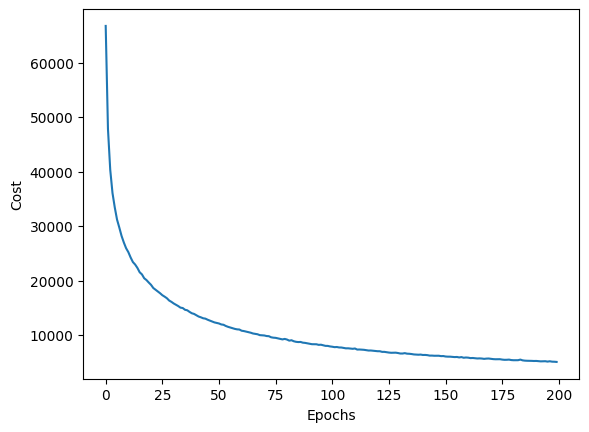

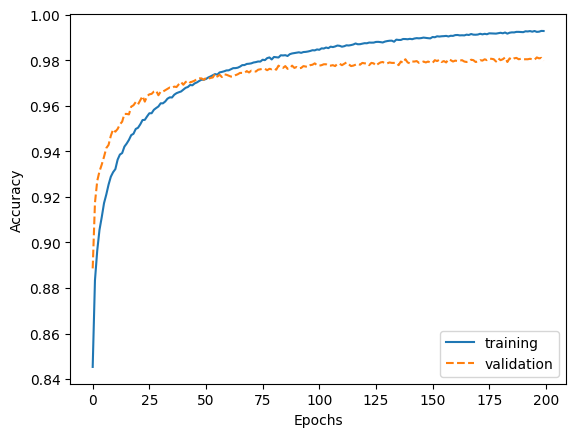

In [39]:
import matplotlib.pyplot as plt

plt.plot(range(nn.epochs), nn.eval_['cost'])
plt.ylabel('Cost')
plt.xlabel('Epochs')

plt.show()


plt.plot(range(nn.epochs), nn.eval_['train_acc'], label='training')

plt.plot(range(nn.epochs), nn.eval_['valid_acc'], label='validation', linestyle='--')

plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')

plt.show()

# **Checking the Test Set Accuracy**

In [41]:
y_test_pred = nn.predict(X_test)

acc = (np.sum(y_test == y_test_pred).astype(float) / X_test.shape[0])

print('Test accuracy: %.2f%%' % (acc * 100))

Test accuracy: 97.54%
